In [1]:
import qiskit as qsk, numpy as np, matplotlib.pyplot as plt
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Resize
from qiskit.quantum_info import SparsePauliOp, Statevector, Clifford, PauliList
from typing import Callable
from functools import lru_cache
from timeit import default_timer as timer

def random_thetas(shape: "shape"):
    possible_theta_values = np.pi / 2 * np.arange(4)
    # print(possible_theta_values)
    # print(shape)
    return np.random.choice(possible_theta_values, shape)

def evolveSPO(op: SparsePauliOp, other: Clifford) -> SparsePauliOp:
    return SparsePauliOp(
        op.paulis.evolve(other)
    )

def img_to_vec(image: torch.Tensor):
    n = int(np.log2(image.shape[0]))  # Image should be a 2^n x 2^n tensor
    # Convert tensor indices from y,x to y0,y1,...,yn-1,x0,x1,...,xn-1
    image = image.reshape([2 for i in range(2*n)])
    # Permute indices from y0,y1,...,yn-1,x0,x1,...,xn-1 to y0,x0,y1,x1,...,yn-1,xn-1
    image = image.permute([i+j for i in range(n) for j in [0, n]])
    vec = image.flatten()
    return np.array([x for x in vec])

def sumZ(n_qubits: int) -> SparsePauliOp:
    return SparsePauliOp.from_sparse_list(
        [("Z", [i], 1) for i in range(n_qubits)],
        num_qubits = n_qubits
    )

mnist_train = MNIST("./data",
                    train= True,
                    transform= ToTensor(),
                    download= True)

def get_image(idx: int, dataset, n_qubits: int):
    image, label = dataset[idx]
    size = 2**(n_qubits//2)
    padded_image = torch.zeros([size, size])
    padded_image[:28, :28] = image.squeeze()[:, :]
    return padded_image

def get_index_from_label(
        qc: qsk.QuantumCircuit,
        label,
        starting_index: int = 0,
        reverse_search_order: bool = False
) -> int:
    for i, instruction in enumerate(qc.data[starting_index:]):
        if instruction.label == label: return i + starting_index
    raise ValueError(f"Label {label} not found in circuit")

class ParametricCircuit:
    def __init__(self):
        self.n_parameters: int = None
        self.params_shape: "shape" = None

        self.cache_heads: dict[str, Clifford] = {}
        self.cache_tails: dict[str, Clifford] = {}
    
    def __call__(self, thetas: np.ndarray, *args, **kwds) -> qsk.QuantumCircuit:
        pass

    def single_gate_clifford(self, label: str, theta_shift: float) -> Clifford:
        pass

    def cache_circuit_segments(self):
        pass

class Model:
    def __init__(self,
                 parametric_circuit: ParametricCircuit,
                 encoding: Callable[..., Statevector],
                 observable: SparsePauliOp
                 ):
        self.param_circ = parametric_circuit
        self.enc = encoding
        self.obs = observable
        self.use_inefficient_method: bool = False
        self.cache_plus: dict = {}
        self.cache_minus: dict = {}
        self.cache_obs_plus: dict = {}
        self.cache_obs_minus: dict = {}


    # def inefficient_call(self, thetas: np.ndarray, input) -> float:
    #     psi = self.enc(input)
    #     qc = self.param_circ(thetas)
    #     evolved_psi = psi.evolve(qc)
    #     return evolved_psi.expectation_value(self.obs)

    def __call__(self, thetas: np.ndarray, input) -> float:
        psi = self.enc(input)
        qc = self.param_circ(thetas)
        if self.use_inefficient_method == False:
            evolved_ops = evolveSPO(self.obs, Clifford(qc))
            return psi.expectation_value(evolved_ops)
        else:
            evolved_psi = psi.evolve(qc)
            return evolved_psi.expectation_value(self.obs)
    
    def param_shift_rule_grad(self, thetas: np.ndarray, input, index: tuple[int]) -> float:
        # print(f"Relevant theta = {thetas[index]}")
        thetas[index] += np.pi / 2
        # print(f"Relevant theta = {thetas[index]}")
        value_plus = self.__call__(thetas, input)
        # print(f"Value plus = {value_plus}")
        thetas[index] -= np.pi
        # print(f"Relevant theta = {thetas[index]}")
        value_minus = self.__call__(thetas, input)
        thetas[index] += np.pi/2
        # print(f"Value minus = {value_minus}")
        return (value_plus - value_minus) / 2
    
    def empirical_NTK(self, thetas: np.ndarray, input1, input2) -> float:
        grad = self.param_shift_rule_grad
        # print(
        #     np.array([
        #         self.param_shift_rule_grad(thetas, input1, index) #* grad(thetas, input2, index)
        #         for index in np.ndindex(thetas.shape)
        #     ])
        # )
        return np.sum([
            grad(thetas, input1, index) * grad(thetas, input2, index)
            for index in np.ndindex(thetas.shape)
        ])
    
    def analytic_NTK(self, input1, input2, n_shots):
        return np.mean([
            self.empirical_NTK(random_thetas(self.param_circ.params_shape),
                               input1, input2)
            for _ in range(n_shots)
        ])
    
    def cache_ops(self):
        for i in range(self.param_circ.n_parameters):
            head = self.param_circ.cache_heads[str(i)]
            tail = self.param_circ.cache_tails[str(i)]
            self.cache_minus[str(i)] = head.compose(
                self.param_circ.single_gate_clifford(str(i), -np.pi/2)
            ).compose(head)
            self.cache_plus[str(i)] = head.compose(
                self.param_circ.single_gate_clifford(str(i), np.pi/2)
            ).compose(tail)
    
    def cache_ops_obs(self):
        for k, v in self.cache_plus.items():
            self.cache_obs_plus[k] = evolveSPO(self.obs, v)
        for k, v in self.cache_minus.items():
            self.cache_obs_minus[k] = evolveSPO(self.obs, v)
    
    def new_grad(self, thetas: np.ndarray, psi):
        out = []
        for i in range(self.param_circ.n_parameters):
            # op_plus = evolveSPO(self.obs, self.cache_plus[str(i)])
            # op_minus = evolveSPO(self.obs, self.cache_minus[str(i)])
            op_plus = self.cache_obs_plus[str(i)]
            op_minus = self.cache_obs_minus[str(i)]
            out.append(1/2 * (psi.expectation_value(op_plus) - psi.expectation_value(op_minus)))
        return np.array(out)
    
    def new_emp_NTK(self, thetas: np.ndarray, input1, input2, use_caches: bool = False,
                    use_caches_states: bool = False):
        time0 = timer()
        if not use_caches: self.param_circ(thetas)
        time1 = timer()

        print(time1 - time0)

        if not use_caches: self.param_circ.cache_circuit_segments()
        time2 = timer()
        print(time2 - time1)
        if not use_caches:
            self.cache_ops()
            self.cache_ops_obs()
        time3 = timer()

        if not use_caches_states:
            self.psi1 = self.enc(input1)
            self.psi2 = self.enc(input2)

        print(time3 - time2)
        return np.dot(
            self.new_grad(thetas, self.psi1),
            self.new_grad(thetas, self.psi2)
        )


    # This function is all wrong, I have to structure it better. The single_gate_cliff should
    # have a shifted theta, not the same theta.
    # def new_emp_NTK(self, thetas: np.ndarray, input1, input2) -> float:
    #     cliff_cache: dict = {}
    #     for i in range(self.param_circ.n_parameters):
    #         cliff_cache[str(i)] = self.param_circ.cache_heads[str(i)].compose(
    #             self.param_circ.single_gate_clifford(str(i))
    #         ).compose(
    #             self.param_circ.cache_tails[str(i)]
    #         )

    


class SimpleTestCircuit(ParametricCircuit):
    def __init__(self, n_qubits: int):
        self.n_parameters: int = n_qubits
        self.params_shape: tuple[int] = (n_qubits)

        self.cache_heads: dict[str, Clifford] = {}
        self.cache_tails: dict[str, Clifford] = {}
    
    def __call__(self, thetas: np.ndarray) -> qsk.QuantumCircuit:
        qc = qsk.QuantumCircuit(self.n_parameters)
        for i in range(self.n_parameters): qc.rx(thetas[i], i)
        return qc

class ConvolutionalQNN(ParametricCircuit):
    def __init__(self, n_qubits: int, n_layers: int):
        self.qc: qsk.QuantumCircuit = None
        self.n_qubits: int = n_qubits
        self.n_layers: int = n_layers
        self.params_shape: tuple[int] = (4, 5*n_qubits//2 - 4, n_layers)
        self.n_parameters: int = np.prod(self.params_shape)
        self.gate_label: int = 0

        self.cache_heads: dict[str, Clifford] = {}
        self.cache_tails: dict[str, Clifford] = {}

    def elementary_2_qubit_gate(self, thetas: np.ndarray, qubit1: int, qubit2: int):
        self.qc.rx(thetas[0], qubit1, label= str(self.gate_label))
        self.gate_label +=1

        self.qc.rx(thetas[1], qubit2, label= str(self.gate_label))
        self.gate_label +=1
        
        self.qc.cx(qubit1, qubit2)
        
        self.qc.rz(thetas[2], qubit1, label= str(self.gate_label))
        self.gate_label +=1
        
        self.qc.rz(thetas[3], qubit2, label= str(self.gate_label))
        self.gate_label +=1
    
    def layer(self, thetas: np.ndarray):
        i = 0
        def apply_gate(qubit1: int, qubit2: int):
            nonlocal i
            self.elementary_2_qubit_gate(thetas[:, i], qubit1, qubit2)
            i += 1
        
        def xiyi_gates(central_qubit: int):
            if central_qubit>0: apply_gate(central_qubit-2, central_qubit-1)
            apply_gate(central_qubit, central_qubit+1)
            if central_qubit<self.n_qubits-2: apply_gate(central_qubit+2, central_qubit+3)
        
        def xxyy_gates(lower_qubit: int):
            apply_gate(lower_qubit, lower_qubit+2)
            apply_gate(lower_qubit+1, lower_qubit+3)
        
        for qubit in np.arange(0, self.n_qubits-2, 2):
            xiyi_gates(qubit)
            xxyy_gates(qubit)
        xiyi_gates(self.n_qubits-2)
    
    def __call__(self, thetas):
        self.gate_label = 0
        self.qc = qsk.QuantumCircuit(self.n_qubits)
        for i in range(self.n_layers):
            self.layer(thetas[:,:,i])
            self.qc.barrier()
        return self.qc
    
    def cache_circuit_segments(self):
        for i in range(self.n_parameters):
            index = get_index_from_label(self.qc, str(i), i)

            head = qsk.QuantumCircuit(self.n_qubits)
            tail = qsk.QuantumCircuit(self.n_qubits)
            
            head.data = self.qc.data[:index]
            tail.data = self.qc.data[index+1:]
            
            self.cache_heads[str(i)] = Clifford(head)
            self.cache_tails[str(i)] = Clifford(tail)
    
    def single_gate_clifford(self, label: str, theta_shift: float) -> Clifford:
        index = get_index_from_label(self.qc, label)
        instruction = self.qc.data[index : index + 1]
        instruction[0].operation.params[0] += theta_shift
        qc_single_gate = qsk.QuantumCircuit(self.n_qubits)
        qc_single_gate.data = instruction
        return Clifford(qc_single_gate)




In [2]:
# Test how much time does a single NTK take

n_qubits = 10
n_layers = 3
img_index = 0

conv_qnn = ConvolutionalQNN(n_qubits, n_layers)
img = get_image(img_index, mnist_train, n_qubits)


model = Model(
    conv_qnn,
    lambda img: Statevector(img_to_vec(img)),
    sumZ(n_qubits)
)
thetas = random_thetas(model.param_circ.params_shape)


In [3]:
model.empirical_NTK(thetas, img, img)

np.complex128(11647.21621120534+0j)

In [4]:
model.new_emp_NTK(thetas, img, img)

0.0009861580001597758
4.1779635659986525
0.5664866850001999


np.complex128(56133.858385143525+0j)

In [6]:
psi = model.enc(img)
operator = sumZ(n_qubits)
start_time = timer()

psi.expectation_value(operator)
end_time = timer()
print((end_time - start_time)*500)

0.15935999999783235


In [7]:
vector = np.random.random(2**n_qubits)
mat = np.random.random((2**n_qubits, 2**n_qubits))

start_time = timer()

for i in range(1000):
    vector = np.random.random(2**n_qubits)
    mat = np.random.random((2**n_qubits, 2**n_qubits))
    vector.dot(mat.dot(vector))

end_time = timer()

(end_time - start_time)*1

7.168112491001011

In [8]:
start_time = timer()
model.new_emp_NTK(thetas, img, img, True, True)
end_time = timer()
print(end_time - start_time)

8.999995770864189e-08
3.441599983489141e-05
6.511001629405655e-06
0.1556946680011606


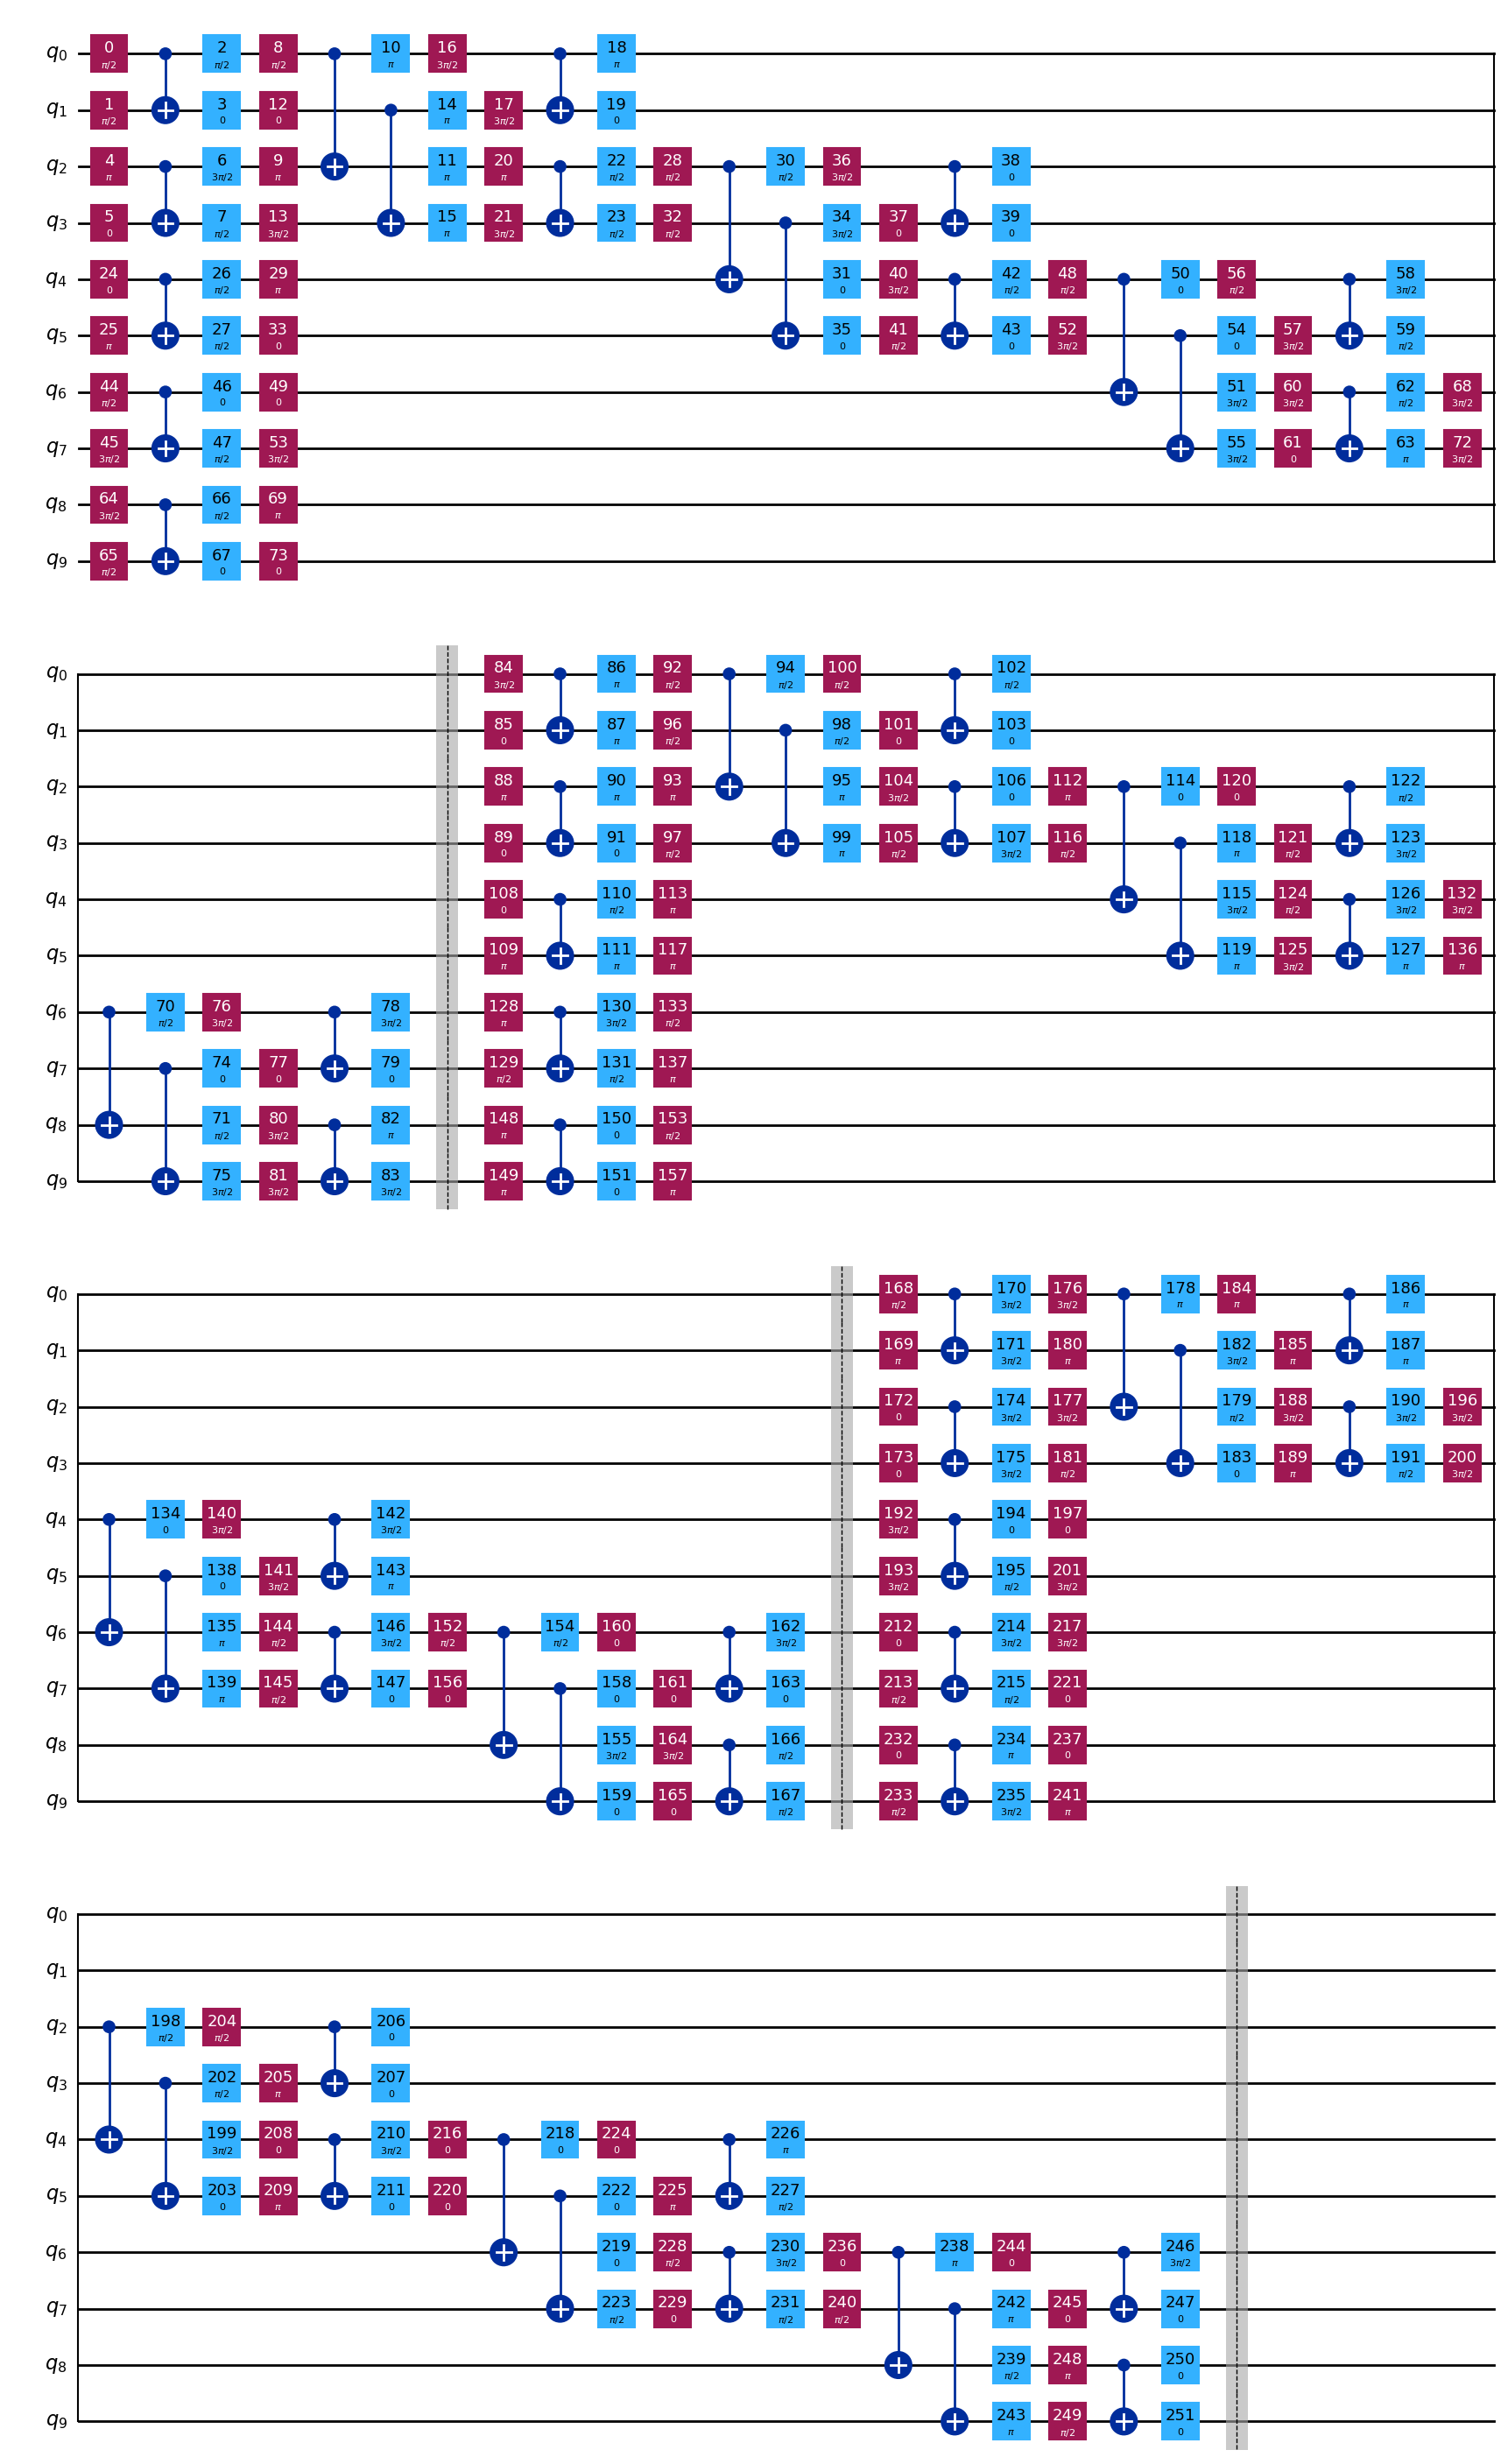

CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), qubits=(<Qubit register=(10, "q"), index=0>,), clbits=())
CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), qubits=(<Qubit register=(10, "q"), index=1>,), clbits=())
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(10, "q"), index=0>, <Qubit register=(10, "q"), index=1>), clbits=())
CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), qubits=(<Qubit register=(10, "q"), index=0>,), clbits=())
CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.0]), qubits=(<Qubit register=(10, "q"), index=1>,), clbits=())
CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[3.141592653589793]), qubits=(<Qubit register=(10, "q"), index=2>,), c

In [38]:
# Test: changing/extracting only one gate from the qc
from IPython.display import display
qc = conv_qnn(thetas)
display(qc.draw("mpl"))
for instruction in qc.data:
    print(instruction)

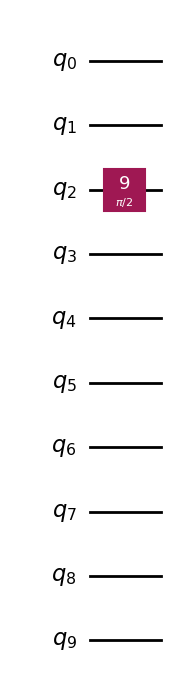

In [39]:
conv_qnn.single_gate_clifford("9", -np.pi/2).draw("mpl")


# inst = data
# inst[0].operation.params[0] += np.pi/2
# modded_gate = qsk.QuantumCircuit(n_qubits)
# modded_gate.data = inst
# modded_gate.draw("mpl")